## Take-home exam

#### Mark de Kwaasteniet
#### 2649271

In [1]:
%reset
import numpy as np
import pandas as pd
import numpy.random as npr
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import scipy
import scipy.stats
import nltk
from scipy.stats import norm
from nltk.sentiment.vader import SentimentIntensityAnalyzer

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Question 1

### Creating functions
This code is dedicated to creating functions that would otherwise require repeating the same multiple lines of code, creating a more clean and structured code. 

In [2]:
#Before making this function i have checked on missing values and data types using the functions .dtypes and .isnull()
def data_prep(file, date_variable, datetime_format):
    #Load in the csv data set from CRSP
    df = pd.read_csv(file)
    
    #Convert the date column values into a datetime variable.
    df[date_variable] = pd.to_datetime(df[date_variable], format=datetime_format)

    #Set date column as an index for the dataframe
    df = df.set_index([date_variable])
    
    return df

In [3]:
#Creating a function for the graphs that we have to make in this assignment.

#Set the characteristics of the plot
colors = ['purple', 'green', 'black', 'red']
lines = ['solid', 'solid', 'dashed', 'dotted']
size = [12, 8]
fontsize = 20
fonttype = 'Times New Roman'
fontcolor = 'black'

def graph_creator(df, plot_variables, labels, title):
    
    #Create plot area including axis
    fig, ax = plt.subplots()

    #Set the size of the plot
    fig.set_size_inches(size)

    for i,r in enumerate(variables):      
        ax.plot(df.index, df[r], color = colors[i], linestyle=lines[i], label = r)  #Denote the Y and X variable. Then plot the line of both dataframes.

    #Organize the tickers with an interval and rotation, making the time better readable.
    fig.autofmt_xdate() #

    #Create a legend for the figure
    ax.legend()

    #Set the labels for the axes.
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    plt.title(title[0], fontsize=fontsize, color=fontcolor, fontname=fonttype)

### Data input
These lines are dedicated to reading the WRDS data, inspecting the values and merging them into dataframes that we can do analyses with.

In [4]:
#Prepare the data files into a dataframe
df_crsp = data_prep('crsp.csv','date', '%Y%m%d')
df_ff = data_prep('ffmom.csv','dateff', '%Y%m%d')

#Merge the CRSP dataset with the FFMOM dataset. They have the same index and same time period.
df_crsp_ff = pd.merge(df_ff,df_crsp,left_index=True, right_index=True)

Reading the Complaints file that is given as a file on Canvas.

In [5]:
#The complaints file is not yet filtered on the dates. Therefore, it is not similar to the CRSP data. 
#Specificy the begin date and the end date. Since, 2020-06 is our last month, we want the months before 2020-07.
begin_date = '2013-01'
end_date = '2020-07'

In [6]:
#Prepare the data file into a dataframe
df_cmplnt = data_prep('complaints.csv.zip','Date received','%Y-%m-%d')

#Store the names of the company we need to filter out of the df. This makes it easy to call the list of strings and look structured.
companies_interest = 'JPMORGAN CHASE & CO.'

#Filter the data set on JPM and store it in the dataframes.
df_cmplnt = df_cmplnt[df_cmplnt['Company'].str.contains(companies_interest)]

#Create a counter variable for every product complain. This will make summing up the number of complaints easier.
df_cmplnt['cmplnt_counter'] = 1

#Create new column for the plot where it returns 1 if row contains a narrative in the complaint.
df_cmplnt['nrtv_counter'] = np.where(df_cmplnt['Consumer complaint narrative'].notna() != False, 1, 0)

#Create new column for the plot where it returns 1 if row contains no narrative in the complaint.
df_cmplnt['no_nrtv_counter'] = np.where(df_cmplnt['Consumer complaint narrative'].notna() != True, 1, 0)

#Create a data set including only the values within the specific time period.
df_cmplnt = df_cmplnt.loc[(df_cmplnt.index > begin_date) & (df_cmplnt.index < end_date)]

Creating a Dataframe that contains only the narrative complaints to run the VADER sentiment analyzer on.

In [7]:
#Using the sentiment analyzer to analyze the sentiment of the narrative complaints in the complaints dataframe.
analyzer = SentimentIntensityAnalyzer()

#Define a quick function to get the sentiment compound score.
def get_sentiment(complaint):
    return analyzer.polarity_scores(complaint)['compound']

In [8]:
#Extract a part of the dataframe from the original dataframe, by only taking the complaints with a narrative in the row.
df_cmplnt_nrtv = df_cmplnt.loc[df_cmplnt.nrtv_counter == 1]

#Use the sentiment function to calculate the compound sentiment score of every complaint in the new dataframe.
df_sent = df_cmplnt_nrtv.assign(sentiment_score = df_cmplnt_nrtv['Consumer complaint narrative'].apply(get_sentiment))

#Specificy the column of interest that twe want to keep.
sentiment_column = ['sentiment_score']

#Create a dataframe that only keeps the sentiment score of every complaint at time point t.
df_sent = df_sent.copy()[sentiment_column]


#Use the begin and end date (specified earlier) to extract only the dates of interest.
df_sent = df_sent.loc[(df_sent.index > begin_date) & (df_sent.index < end_date)]

Creating a Dataframes that contains all the complaints and sentiment scores on a quarterly interval, to create the graphical representations in Task 1.

In [9]:
#Resample the dataframe containing the sentiment scores to quarterly scores, using both the mean and the median.
df_sent_qrt = df_sent.resample('QS').mean()
df_sent_qrt = df_sent_qrt.rename(columns={"sentiment_score": "sent_mean"})
df_sent_qrt['sent_median'] = df_sent.resample('QS').median()

#Resample the dataframe containing the complaint counters to quarterly numbers, using both the sum of the complaints.
df_cmplnt_qrt = df_cmplnt.resample('Q').sum()

#Create a new column for the proportion of complaints without a narrative. We could also put this formula directly into the graph, however this looks more structured.
df_cmplnt_qrt = df_cmplnt_qrt.assign(prop_no_nrtv = (df_cmplnt_qrt.no_nrtv_counter / df_cmplnt_qrt.cmplnt_counter))

## Task 1
Producing the graphical representations of the following three figures:
1. Number of complaints with a complaint narrative per quarter
2. Proportion of complaints without a narrative each quarter
3. Average and median compound sentiment score per quarter (for those complaints which have a narrative).

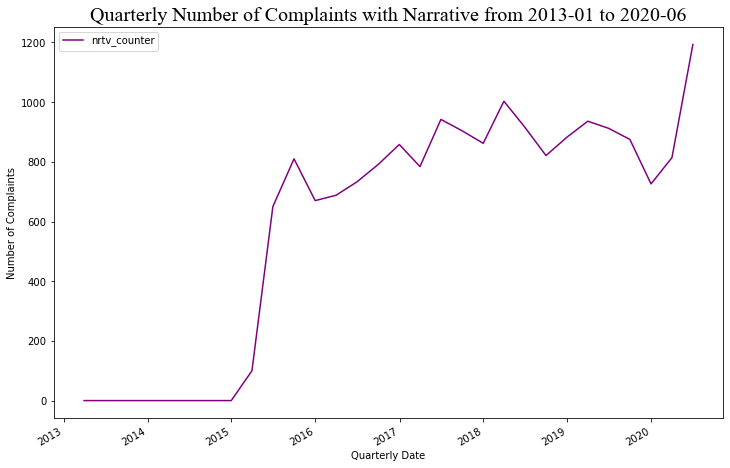

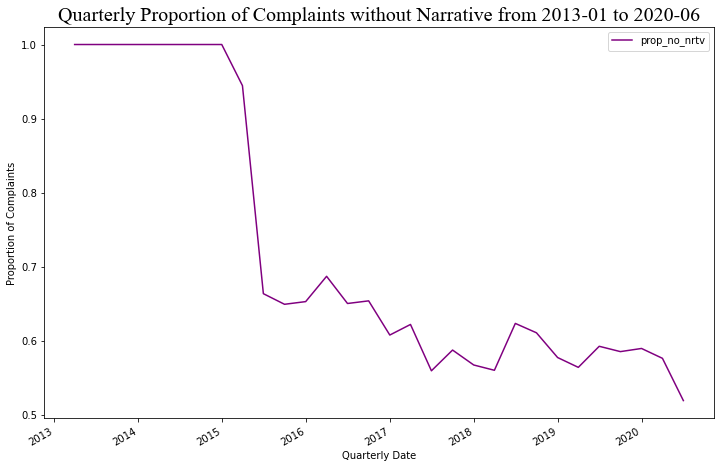

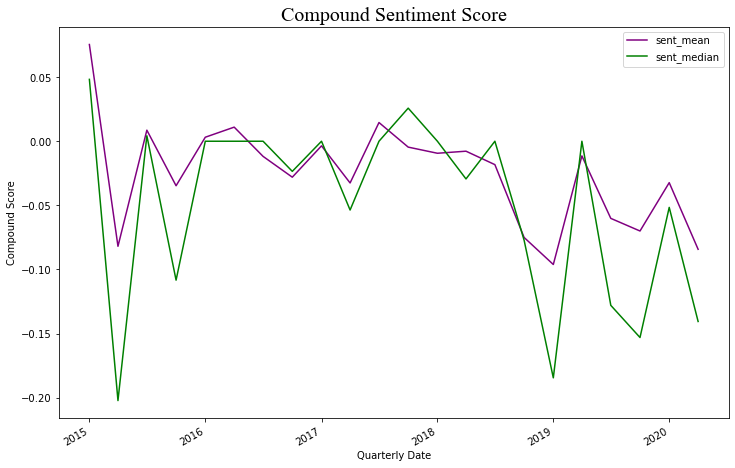

In [10]:
#Create graph 1. Number of complaints with a complaint narrative per quarter
graph_labels = ['Quarterly Date', 'Number of Complaints']
graph_title = ['Quarterly Number of Complaints with Narrative from 2013-01 to 2020-06']
variables = ['nrtv_counter']
graph_creator(df_cmplnt_qrt, variables, graph_labels, graph_title)

#Create graph 2. Proportion of complaints without a narrative each quarter
graph_labels = ['Quarterly Date', 'Proportion of Complaints']
graph_title = ['Quarterly Proportion of Complaints without Narrative from 2013-01 to 2020-06']
variables = ['prop_no_nrtv']
graph_creator(df_cmplnt_qrt, variables, graph_labels, graph_title)

#Create Graph 3. Average and median compound sentiment score per quarter (for those complaints which have a narrative).
graph_labels = ['Quarterly Date', 'Sentiment Score']
graph_title = ['Compound Sentiment Score','Compound Sentiment Score from 2013-01 to 2020-06']
variables = ['sent_mean','sent_median']
graph_creator(df_sent_qrt, variables, graph_labels, graph_title)

#### Interpretation of the graphs
1. We see that there are no narrative complaints in time period 2013 till 2015. After 2015 it sets around a value of 800 complaints per quarter. It could be important to know for further analysis that the first two years of our dataframe do not have narrative complaints.
2. Since, the first two year don't have narrative complaints, the proportion of complaints without a narrative is equal to 1, because all the complains are without a narrative (100%). After the two years, it sets around 60%, meaning that around 60% of the total complaints are without a narrative. 
3. We see that both the average and the median compound scores of the complaints are more often negative than positive. This means that the narrative in the complaint more often contains negative text than positive. This is not unlikely, since a complaint is often something people aren't happy about.

### Preperation for Task 2
Creating a dataframe contains both the complaints dataframe and the CRSP dataframe on a monthly basis.

In [11]:
#To make sure the timestamps are matched up
df_crsp_ff = df_crsp_ff.resample('M').mean()

#Resample the original sentiment dataframe that is in daily timestamps.
df_sent_mnth = df_sent.resample('M').mean()

#Join the sentiment dataframe monthly, to the crsp file. Note: this way, the missing values of the sentiment dataframe will be filled in by NaN.
df_crsp_ff_sent = df_crsp_ff.join(df_sent_mnth)

#Create the excess return variable.
df_crsp_ff_sent = df_crsp_ff_sent.assign(excess_return = df_crsp_ff_sent.RET - df_crsp_ff_sent.rf)

## Task 2
First estimate the following model:

$R_{JPM,t} - R_{f,t} = \alpha + \beta_1MKTRF_{t} + \beta_2HML_{t} + \beta_3SMB_{t} + \beta_4MOM_{t} + \epsilon_{t}$

In [12]:
#We estimate the model using OLS
exret_model = ols("excess_return~mktrf+hml+smb+umd", df_crsp_ff_sent)

#Then we fit the model
exret_est = exret_model.fit()

#We don't need the coefficients, we only want to store the residuals
df_crsp_ff_sent = df_crsp_ff_sent.assign(residuals = exret_est.resid)

Then we store the residuals ($\epsilon_t$) of the estimated model. Using the residuals, we estimate the following regression:

$\epsilon_{t} = \alpha + \beta_1c_t + \beta_2c_{t-1}$

In [13]:
#We estimate the model of the residuals using OLS
residuals_model = ols("residuals~sentiment_score + sentiment_score.shift(1)", df_crsp_ff_sent)

#Then we fit the model
resid_est = residuals_model.fit()

#Check the summary of the estimated model to interpret the coefficients
resid_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     2.061
Date:                Wed, 20 Oct 2021   Prob (F-statistic):              0.136
Time:                        14:34:38   Log-Likelihood:                 133.00
No. Observations:                  63   AIC:                            -260.0
Df Residuals:                      60   BIC:                            -253.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0030      0.005     -0.617      0.539      -0.013       0.007
sentiment_score             -0.0801      0.077     -1.039      0.303      -0.234       0.074
sentiment_score.shift(1)    -0.1231      0.074     -1.653      0.104      -0.272       0.026
==============================================================================
Omnibus:                        1.359   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.507   Jarque-Bera (JB):                0.908
Skew:                           0.289   Prob(JB):                        0.635
Kurtosis:                       3.114   Cond. No.                         20.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpretation of the estimated model
The Average Compound Score is not able to predict the residuals from the four-factor market model. Both of the coefficients ($\beta_1$ and $\beta_2$) are not statistically significant at 5%, meaning that they don't significantly affect the value of the dependent variable, the residuals. 

If it would have been able to predict the residuals, which it hasn't been, then we could explain the part of the excess return of a company that is unexplained by the four-factors by looking at the complaints (in particular the compound score of the complaints) of a company.

# Question 2


### Task 1a: Stock Price Simulation
Creating two functions:
1. Slow function that creates the stock price paths using for loops and is therefore relatively slow.
2. Fast function that creates the stock price paths using numpy, vectorizing methods, being faster than the slow function.

In [14]:
# Number of paths that need to be simulated
path = 5000

# Number of timesteps for the simulator to create stock prices for
timesteps = 1000

# Number of years that need to be simulated.
years_sim = 2

# The assumed volatility that is given.
volatility_asset = 0.22

# The start price of the stock.
start_price = 50

# The assumed risk free rate.
rf_rate = 0.05

# The seed number that is given, so that np.random will have the same random choice every run.
seed_number = 3011

# Reading/writing order in which we reshape the matrices
rw_order = 'F' # Order F, meaning that the first index with change fastest and last index changest slowest

Note: A large part of the slow and the fast function is identical (probabilities). We could easily take this outside the function, creating a more efficient code. However, since the task clearly states that we should use the function with the given characteristics, we use the following code:

#### Slow function

In [15]:
def price_paths_slow(n, m, T, v, S, r):
    #Since, we need to set the seed before running each function, we put it inside the function.
    np.random.seed(seed_number) # The seed number is already set outside the function, since this is constant over question 2.
    
    #We determine the delta of t: The number of simulation years divided by the number of time steps.
    delta_t = T/m
    
    #Then we determine the return + 1 of a stock price going up. Using the formula given in question 2.
    ret_up = np.exp(v*np.sqrt(delta_t))
    
    #Then we determine the return + 1 of a stock price going down
    ret_down = 1/ret_up
    
    #Using the risk neutral probability, we determine the probability of the stock price going up (prob of ret_up happening)
    prob_up = (np.exp(r*delta_t)-ret_down)/(ret_up-ret_down) #Using the formula given in question 2.
    
    #We determine the probability of the stock price going down. Using the formula given in question 2.
    prob_down = 1-prob_up
    
    #We create a matrix full of zero's. The size of the matrix is as big as: C * R (question 2)
    # C = the number of stock-price-paths you simulate
    # R = the number of time-steps simulated plus one row with the initial price (i.e. R = m + 1)
    prices_slow = np.zeros((m+1,n))
    
    #We change the first row of the matrix, from zero's to the initial starting price that we start calculating with.
    prices_slow[0,:] = S
    
    #We create another matrix that is equal to size of the zero's in the price_slow matrix.
    #In this new matrix we store all the probabilities of the stock price going up an down. 
    #Using Numpy Random Choice, it will choose randomly (with the calculated probabilities) between two values, return up and down.
    probability = npr.choice((ret_down,ret_up), n*m, p=[prob_down,prob_up])
    
    #Then we reshape this list into a matrix. 
    return_matrix = np.reshape(probability, (m,n),order = rw_order)
    
    #Then we loop over all the number of paths that we are simulating.
    for i in range(0,n):
        
        #In the given path, we loop over the number of timesteps.
        for j in range(0,m):
            
            #The next price will be equal to the price before times the return (up or down)
            prices_slow[j+1,i] = prices_slow[j,i]*return_matrix[j,i]
    
    #Return the matrix with all the prices.
    return prices_slow

#### Fast function


In [16]:
def price_paths_fast(n, m, T, v, S, r):
    #Since, we need to set the seed before running each function, we put it inside the function.
    np.random.seed(seed_number)
    
    #We determine the delta of t: The number of simulation years divided by the number of time steps.
    delta_t = T/m
    
    #Then we determine the return + 1 of a stock price going up. Using the formula given in question 2.
    ret_up = np.exp(v*np.sqrt(delta_t))
    
    #Then we determine the return + 1 of a stock price going down
    ret_down = 1/ret_up
    
    #Using the risk neutral probability, we determine the probability of the stock price going up (prob of ret_up happening)
    prob_up = (np.exp(r*delta_t)-ret_down)/(ret_up-ret_down) #Using the formula given in question 2.
    
    #We determine the probability of the stock price going down. Using the formula given in question 2.
    prob_down = 1-prob_up
    
    #We create a matrix (1 row) of all starting values and the length of the number of paths.
    row = 1
    starting_prices = np.full((row, n), S)
    
    
    #We create another matrix that is equal to size of the zero's in the price_slow matrix.
    #In this new matrix we store all the probabilities of the stock price going up an down. 
    #Using Numpy Random Choice, it will choose randomly (with the calculated probabilities) between two values, return up and down.
    probability = npr.choice((ret_down,ret_up), n*m, p=[prob_down,prob_up])
    
    #Then we reshape this list into a matrix and take the cumulative products over every column in the matrix.
    return_matrix = np.cumprod(np.reshape(probability, (m,n), order=rw_order),axis=0)
    
    #Now we have one matrix with all the cumulative products and one array with starting values.
    #If we multiply them, we have all the stock prices at every timestep and for every path.
    stock_prices = np.multiply((return_matrix),starting_prices)
    
    #We have a matrix of (m,n) without the initial starting values. Therefore, we concatenate these to the matrix.
    prices_fast = np.concatenate((starting_prices, stock_prices), axis=0)
    
    #Return the matrix with all the prices.
    return prices_fast

#### Note:
The comments might be too detailed for the code. However, since we don't have a report that we can denote out steps in, I try to be as detailed as possible. In that case even beginners in python could somewhat read the code.

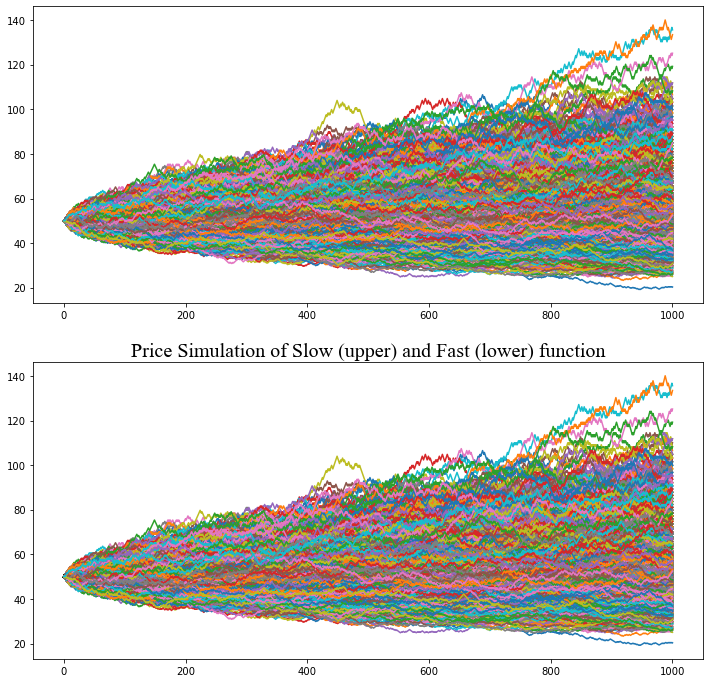

In [35]:
#Make a quick graph, without the graph function earlier. 2 plots.
fig, axs = plt.subplots(2)
fig.set_size_inches(12,12)

#First plot are the slow prices, second plot are the fast prices
axs[0].plot(price_paths_slow(path,timesteps,years_sim,volatility_asset,start_price,rf_rate))
axs[1].plot(price_paths_fast(path,timesteps,years_sim,volatility_asset,start_price,rf_rate))
plt.title('Price Simulation of Slow (upper) and Fast (lower) function', fontsize=fontsize, color=fontcolor, fontname=fonttype)
plt.show()

#### Interpretation of the plots
As we can see from the plots, the stock prices of every path is identical. Meaning that both functions (using a seed of 3011) produce the exact same simulated stock prices for every path. Furthermore, we cannot conclude any statistics like averages or variances from this plot, as there are too many paths in the plot.

## Task 1b: Timing the price functions
Here we will time both the fast and the slow function. First we create a function that will time a specific function that is given.

**Note that in this function:** timesteps, years_sim, volatility_asset, start_price, rf_rate are pre-defined in Task 1.

In [18]:
#We use a rounding of 2 decimals.
roundoff_sec = 2

def time_calc(function, number_paths):
    import time
    
    # Record starting time
    t0 = time.time() 
    
    # Insert the function that we want to time.
    function(number_paths,timesteps,years_sim,volatility_asset,start_price,rf_rate)
    
    # Record ending time
    t1 = time.time() 
    
    # Calculate the difference between the starting time and ending time (and round this off).
    time = round(t1-t0, roundoff_sec)
    
    return time

Here we run the for loop, based on the characteristics of the number of paths, given in the question.

In [19]:
#Set the characteristics of the dataframe we want. Question has given the following characteristics.
start_paths = 500
end_paths = 4000 
steps = 500

#Set a column name for paths
column_pth = ['paths']

#Create a list all the number of paths that we want to loop over.
df_runtime = np.arange(start_paths,end_paths+steps,steps).tolist()

#Create a dataframe that we store the number of paths in.
df_runtime = pd.DataFrame(df_runtime, columns=column_pth)

#Run the for loop over the rows in the dataframe.
for index,row in df_runtime.iterrows():
    
    #Store the time of the slow and fast function in a seperate column.
    df_runtime.loc[index, ['slow_function']] = time_calc(price_paths_slow, int(row[column_pth]))
    df_runtime.loc[index, ['fast_function']] = time_calc(price_paths_fast, int(row[column_pth]))

#Create a new variable, that is the relative running time of the functions.
df_runtime = df_runtime.assign(rel_time = df_runtime.slow_function/df_runtime.fast_function)

#Set the index of the dataframe to the number of paths. This way, we can easily plot it with my function. 
df_runtime = df_runtime.set_index(column_pth)

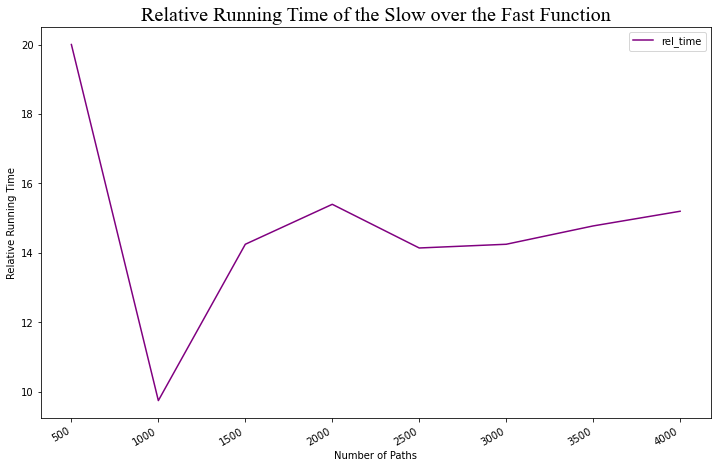

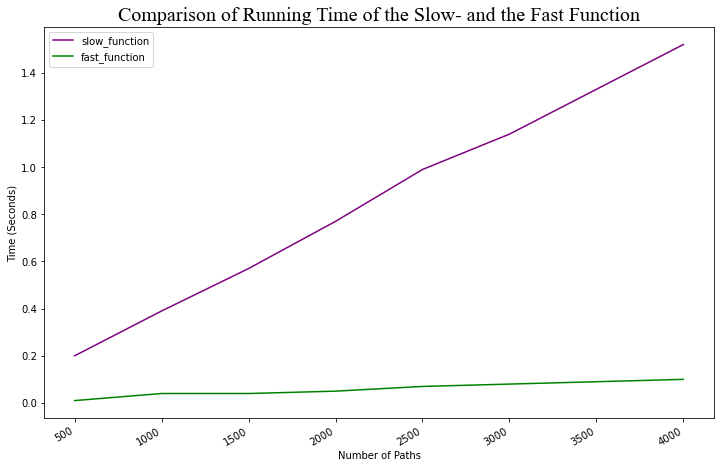

In [20]:
#Create a graph of the relative running time
graph_title = ['Relative Running Time of the Slow over the Fast Function']
graph_labels = ['Number of Paths','Relative Running Time']
variables = ['rel_time']

graph_creator(df_runtime,variables,graph_labels, graph_title)

#Create graph of the absolute running time of the two functions.
graph_title = ['Comparison of Running Time of the Slow- and the Fast Function']
graph_labels = ['Number of Paths','Time (Seconds)']
variables = ['slow_function', 'fast_function']

graph_creator(df_runtime,variables,graph_labels,graph_title)

#### Interpretation of the graphs
1. In the first graph we see that the Relative Running Time has an average (of all the number of paths) of approximately 14, using eye-ball econometrics. Meaning that the fast function is around 14 times as fast as the slow function. This graph tells us that the fast function is way faster than the slow function, however is it is very difficult to read, because my Macbook has a different output (seconds) each time. Eventhough, this difference is very small in absolute terms, it can greatly impact the form of the graph. Every run, it fluctuates around a relative running time of 14.


2. This function is much more stable, since it measures the absolute values. Here we see that the time in second of the slow function linearily increases with the increasing number of path. It has a fairly big slope, meaning that the time it costs to produce 4000 paths is much larger than the time it costs to produce 500 paths. When we compare this to the fast function, which also linearily increases with the number of paths, then this slope is much smaller. We see, that compared to the slow function, it almost doesn't increase at all. **Therefore, the gap in seconds between the slow and fast function will increase when the price paths increase.**

## Task 2: Pricing Call options
Using three different methods to price a European call option:
1. Simulation method (Created in Task 1 of question 2)
2. The Binomial Tree method (Given in Class)
3. The Black Scholes method (Given in Class)

Note that the simulation methods uses the price_paths_fast function that is defined earlier in the exercise. For grading simplicity, we use the exact same function parameters for the simulated call and the binomial call.

**Simulation method**

In [21]:
def simulated_call(S0,T,m,rf,E,sigma,n):
    
    #First the simulated stock prices are being calculted using the same function as before.
    stock_prices = price_paths_fast(n,m,T,sigma,S0,rf)
    
    #Then we extract the last row of the matrix, which are the final prices of all the stocks (paths).
    final_prices = stock_prices[-1,:]
    
    #We determine the call value by subtracting the strike price from the final prices.
    call_price = final_prices-E
    
    #We check werther the call value is lower than zero. If this is the case, then we set this value equal to zero,
    #because nobody will exercise his/her call when the value is negative. Thus the price = 0.
    call_price = call_price.clip(min=0)
    
    #These call_values are all at the last timestep. Meaning we should discount them to determine the present value.
    pv_price = call_price / np.exp(rf * T)
    
    #We return the mean of the present call value of all the stocks (number of paths).                                        
    return np.mean(pv_price)

**Binomial Tree method** (exactly copied)

In [22]:
def binomial_call(S0,T,m,rf,E,sigma):
    dt = T/m
    # Compute steps for tree: u and d
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    # Compute the probability of up
    p = (np.exp(rf*dt)-d)/(u-d)
    # Setup stock price and call value matrix
    # We need m+1 rows and columns due to the zero state!
    s = np.zeros((m+1,m+1))
    c = np.zeros((m+1,m+1))
    # Initialize stock price
    s[0,0] = S0
    
    # Compute all stock prices
    for i in range(1,m+1):
        # Loop over time periods
        for j in range(0,i+1):
            # Loop over states in a single time period
            if j == 0: # This is an up state
                s[j,i] = s[j,i-1]*u
            elif j > 0:
                s[j,i] = s[j-1,i-1]*d
    
    # Compute call value
    # We know the call value at the very last step
    c[:,m] = s[:,m] - E
    c[c < 0] = 0
    # We now reverse the order and go from the end back
    # to the beginning to compute the call value
    for i in range(m-1,-1,-1):
        for j in range(0,i+1):
                c[j,i] = (p*c[j,i+1]+(1-p)*c[j+1,i+1])*np.exp(-rf*dt)
    
    return c[0,0] # Return Discounted price

**Black Scholes method** (exactly copied)

In [23]:
def bs_call(S,E,sigma,T,rf):
    # Compute discount factor
    df = np.exp(-rf*T)
    d1 = np.log(S/(E*df))/(sigma*np.sqrt(T)) + sigma*np.sqrt(T)/2
    d2 = d1 - sigma*np.sqrt(T)
    c  = norm.cdf(d1) * S - norm.cdf(d2) * E * df
    return c

Set the parameters for all the European Price calculation methods.

In [24]:
# Set the characteristics for all the three methods.
# Number of paths that need to be simulated
path = 3000 #Number of paths is only used by the simulated call price

# Time to maturity
years = 1

# The assumed volatility of the underlying asset
volatility_asset = 0.18

# Starting price of the underlying asset.
start_price = 50

# The assumed risk free rate.
rf_rate = 0.05

# The strike price.
strike_price = 60

# The seed number that is given, so that np.random will have the same random choice every run.
seed_number = 3011

Creating a dataframe that contains all the prices for the European Call Option at different Timesteps.

In [25]:
#Set the characteristics of the dataframe we want. Question has given the following characteristics.
start_steps = 500
end_steps = 3500 
interval = 500

#Set a column name for the time steps
column_ts = ['time_steps']

#Create a list all the number of timesteps that we want to loop over.
df_call = np.arange(start_steps,end_steps+interval,interval).tolist()

#Create a dataframe that we store the number of timesteps in.
df_call = pd.DataFrame(df_call, columns=column_ts)

#Run the for loop over the rows in the dataframe.
for index,row in df_call.iterrows():
    
    #Store the price of the call option of every method in a seperate column.
    df_call.loc[index, ['simulated_price']] = simulated_call(start_price, years, int(row[column_ts]), rf_rate, strike_price, volatility_asset, path)
    df_call.loc[index, ['binomial_price']] = binomial_call(start_price, years, int(row[column_ts]), rf_rate, strike_price, volatility_asset)

#Since the black scholes method does not use timesteps, it will have a constant price for the call over the number of timesteps.
df_call['black_scholes_price'] = bs_call(start_price,strike_price,volatility_asset,years,rf_rate)

#Set the index of the dataframe to the number of timesteps. This way, we can easily plot it with my function.
df_call = df_call.set_index(column_ts)

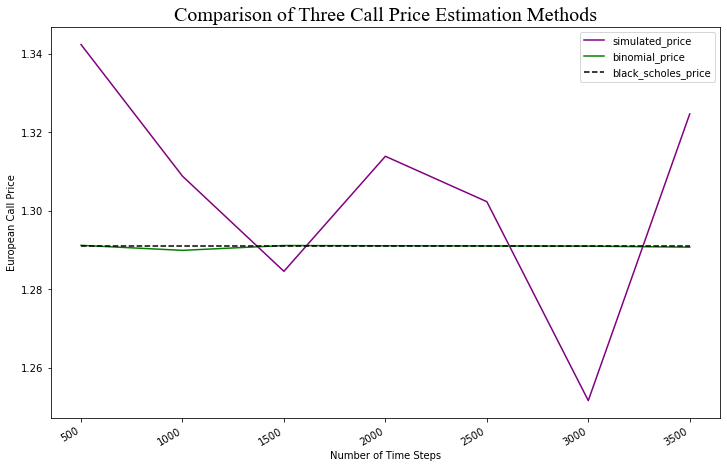

In [26]:
#Create a graph combining all the call prices, calculated with different methods.
graph_title = ['Comparison of Three Call Price Estimation Methods']
graph_labels = ['Number of Time Steps', 'European Call Price']
variables = ['simulated_price', 'binomial_price', 'black_scholes_price']

graph_creator(df_call,variables,graph_labels,graph_title)

#### Interpretation of the graph
First of all, we see that the binomial tree call price is very similar to the black scholes call price, there is only little deviation at a lower number of time steps. This outcome is in line with my expectations as the Binomial Tree method and the Black Scholes method, both use a risk neutral valuation. The main difference between the two methods is that the Binomial Tree method takes the number of timesteps into consideration when valuating a call option. The Black Scholes does not take this into consideration, however it assumes that the timesteps are infinite large. Thus the Black Scholes method is just a special case of the Binomial Tree method. In our case, the number of steps is already very large with a starting point of 500. Meaning that the Binomial Tree method automatically conforms to the call price with infinite time steps.

Second of all, we see that the Simulated price fluctuates somewhat around the Black Scholes and Binomial Tree Price. It is not as close to the Black Scholes price as the Binomial Tree price. This is due to the fact that we only simulate 3000 price paths, which is not enough to conform to the constant price of the Black Scholes method. However, if we would increase the number of price paths significantly, this simulated price would be closer to the constant price of the Black Scholes Method. 